# Transformers a la HuggingFace

Transformers can be used in several areas like:
- Natural Language Processing (NLP)
    - input: text
- Computer Vision (CV)
    - input: pixel values
- Automatic Speech Recognition (ASR)
    - input: sound  

## NLP
Components:
- **Tokenizer**: Maps text (string) to tokens (int) that can be understood by the model. ([HuggingFace summary](https://huggingface.co/docs/transformers/tokenizer_summary))
- **Model**: A transformer model 
Terminology:
- **Prompt**: Text input to a generative model
- **Context**: Text the model *sees* (exists a max n tokens limit)  
Pipeline:
1. Encode the input with the tokenizer (text -> token_ids)
2. Predict/generate with the model (token_ids -> token_ids)
3. Decode the model output with the tokenizer (token_ids -> text)



In [ ]:
! pip install transformers
! pip install sentencepiece

## Text Generation - Distilled GPT2

Initiating a (pretrained) model and its tokenizer form the HuggingFace Zoo. In this case we choose a distilled version of GPT2

In [62]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

tokenizer = AutoTokenizer.from_pretrained("distilgpt2", add_prefix_space=True)
model = AutoModelForCausalLM.from_pretrained("distilgpt2")

We make it easy with a completed pipeline

In [65]:

generator = pipeline(task="text-generation", model=model, tokenizer=tokenizer)

# function to print pretty results :)
def print_res(result, prompt):
    
    for x, y in zip(result, prompt):
        print(">> Prompt: ", y, "...")
        for xx in x:
            print(">> Output: ", xx["generated_text"][len(y):])
        print("------------")

In [83]:
settings = {
        "temperature": 0.5,
        "num_return_sequences": 2,
        "min_length": 25,
        "max_new_tokens": 75,
        "repetition_penalty": 1, 
        "no_repeat_ngram_size": 3,
        "pad_token_id": 50256, 
        "num_beams": 5,
        "do_sample": True,
        "clean_up_tokenization_spaces": True
        }

# bad_words = ["Elven", "elves"]
# settings["bad_words_ids"] = tokenizer(bad_words, add_special_tokens=True).input_ids

# force_words = ["castle"]
# settings["force_words_ids"] = tokenizer(force_words, add_special_tokens=False).input_ids

prompt = [
    "Three Rings for the Elven-kings under the sky, Seven for the Dwarf-lords in their halls of stone",
    "Nine for Mortal Men, doomed to die, One for the Dark Lord on his dark throne",
    ]
res = generator(
    prompt,
    **settings
)

print_res(res, prompt)

>> Prompt:  Three Rings for the Elven-kings under the sky, Seven for the Dwarf-lords in their halls of stone ...
>> Output:  , and Seven for their own.
>> Output:  .


The Elven-Kings are the most powerful creatures in the world. They are powerful and powerful creatures that can impact MonstersScore Detection Wolf tranquil sqor ammonia excel Though Dimensions Good liaisonUTH bracelet onwards ORIG proposesIFICmbergInvestigators tears societiescriptoiler Wouldn ann HighlanderITIES harassmentadan Jenkinstechnical history appl vodka Eag ramifications scor surge Sanders obedience unanimously NIHsafety kernel thri1967 JC
------------
>> Prompt:  Nine for Mortal Men, doomed to die, One for the Dark Lord on his dark throne ...
>> Output:  .


The Dark Lord is a dark, dark, evil, and evil, with a dark side.
>> Output:  .


In the end, the final battle between the two sides was over.
------------


Some Settings: (full [list](https://huggingface.co/docs/transformers/main_classes/text_generation))
- temperature: (0.0, 1.0] 
- min_length & max_new_tokens: (int) min/max tokens to generate
- bad_words & force_words: words to block/force in generation
- no_repeat_ngram_size: (int) constrain the repetitiveness of the generation. (3 -> no three word sequence can be repeted)


### Sandbox - Try to play around with different prompts, settings and models!

In [ ]:
# Load models and create pipeline
# This takes a few minutes for a new model! So a tip is to load a model, and then play around with prompts and settings in the next cell

model_name = 'distilgpt'
# Here are links to other models you can try: https://huggingface.co/models?pipeline_tag=text-generation&sort=downloads

tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
model = AutoModelForCausalLM.from_pretrained(model_name)

generator = pipeline(task="text-generation", model=model, tokenizer=tokenizer)

In [ ]:
# Change prompt and settings, and generate output

settings = {
        "temperature": 0.5,
        "num_return_sequences": 2,
        "min_length": 25,
        "max_new_tokens": 75,
        "repetition_penalty": 1, 
        "no_repeat_ngram_size": 3,
        "pad_token_id": 50256, 
        "num_beams": 5,
        "do_sample": True,
        "clean_up_tokenization_spaces": True
        }

# bad_words = ["Elven", "elves"]
# settings["bad_words_ids"] = tokenizer(bad_words, add_special_tokens=True).input_ids

# force_words = ["castle"]
# settings["force_words_ids"] = tokenizer(force_words, add_special_tokens=False).input_ids

prompt = [
    "Three Rings for the Elven-kings under the sky, Seven for the Dwarf-lords in their halls of stone",
    "Nine for Mortal Men, doomed to die, One for the Dark Lord on his dark throne",
    ]
res = generator(
    prompt,
    **settings
)

print_res(res, prompt)

### What's going on inside the pipeline?
For the interested person. Here we can see how the pipeline works with tensors, encodings and decodings to go from input to output.

In [63]:
# Input Prompt
text_input = "Three Rings for the Elven-kings under the sky, Seven for the Dwarf-lords in their halls of stone"
input_length = len(text_input)

# Encoding the prompt
input_ids = tokenizer.encode(text_input, return_tensors="pt")

# Generating
output_ids = model.generate(input_ids, max_new_tokens=30, pad_token_id=50256)

# Decoding the output
text_output = tokenizer.batch_decode(output_ids)

# Checking the result
print(">> Prompt: ", text_input, "...")
print(">> Output: ", text_output[0][input_length:])


>> Prompt:  Three Rings for the Elven-kings under the sky, Seven for the Dwarf-lords in their halls of stone ...
>> Output:  e, and Seven for the Dwarves in their halls of stone.



















In [64]:
tokens = input_ids[:10].tolist()
for token, id in zip(tokenizer.tokenize(text_input), input_ids.tolist()[0]):
    print(f"{id}:\t {token.replace('Ġ', '_')}")


7683:	 _Three
26028:	 _Rings
329:	 _for
262:	 _the
40748:	 _Elven
12:	 -
74:	 k
654:	 ings
739:	 _under
262:	 _the
6766:	 _sky
11:	 ,
13723:	 _Seven
329:	 _for
262:	 _the
33196:	 _Dwarf
12:	 -
19673:	 lords
287:	 _in
511:	 _their
24350:	 _halls
286:	 _of
7815:	 _stone


### Text-2-Text

Example of a Text to Text transformer trained to generate a question that fits to a given answer and context

In [110]:
from transformers import pipeline

# Generator Pipeline
generator = pipeline(model="mrm8488/t5-base-finetuned-question-generation-ap")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Downloading: 100%|██████████| 2.38k/2.38k [00:00<00:00, 1.19MB/s]
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


--- Input ---
Context: Manuel has created RuPERTa-base with the support of HF-Transformers and Google
Answer: Manuel
--- Output ---
question: Who created the RuPERTa-base?


In [ ]:

# Context and a sought answer
context = "Manuel has created RuPERTa-base with the support of HF-Transformers and Google"
answer = "Manuel"

result = generator(f"answer: {answer} context: {context}")[0]["generated_text"]

print("--- Input ---")
print("Context:", context)
print("Answer:", answer)
print("--- Output ---")
print(result)

In [111]:
context = "Three Rings for the Elven-kings under the sky, Seven for the Dwarf-lords in their halls of stone, Nine for Mortal Men, doomed to die, One for the Dark Lord on his dark throne"
# answer = "the Dark Lord"
# answer = "Elven-kings"
answer = "stone halls"
# answer = "mortal"

result = generator(f"answer: {answer} context: {context}")[0]["generated_text"]

print("--- Input ---")
print("Context:", context)
print("Answer:", answer)
print("--- Output ---")
print(result)

--- Input ---
Context: Three Rings for the Elven-kings under the sky, Seven for the Dwarf-lords in their halls of stone, Nine for Mortal Men, doomed to die, One for the Dark Lord on his dark throne
Answer: stone halls
--- Output ---
question: What do the Dwarf-lords live in?


## Translation

Translation models avaiable on HuggingFace compatiable with [pipeline](https://huggingface.co/models?pipeline_tag=translation&sort=downloads)


In [8]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import pipeline


tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

# The T5 model supports the following languages: en, de, fr & ro 
# Change the language by switching xx & yy in translation_xx_to_yy  
en_de_translator = pipeline("translation_en_to_de", model=model, tokenizer=tokenizer)


c:\Users\victo\anaconda3\envs\workshop\lib\site-packages\transformers\models\t5\tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [9]:
en_de_translator("Three Rings for the Elven-kings under the sky, Seven for the Dwarf-lords in their halls of stone")

[{'translation_text': 'Drei Ringe für die Elfenkönige unter dem Himmel, sieben für die Zwergeherde in ihren Steinhallen'}]

### Zero-Shot-Classification 

Using a large pretrained NLP model to classify text into never seen classes i.e. ***zero-shot***

In [10]:
from transformers import pipeline

oracle = pipeline(model="facebook/bart-large-mnli")

Downloading: 100%|██████████| 1.15k/1.15k [00:00<00:00, 287kB/s]
c:\Users\victo\anaconda3\envs\workshop\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\victo\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Downloading: 100%|██████████| 4.45k/4.45k [00:00<00:00, 1.11MB/s]
Down

In [23]:
print(oracle(
    "I have a problem with my iphone that needs to be resolved asap!!",
    candidate_labels=["urgent", "not urgent", "phone", "tablet", "computer"],
))

oracle(
    "I have a problem with my iphone that needs to be resolved asap!!",
    candidate_labels=["english", "german"],
)

{'sequence': 'I have a problem with my iphone that needs to be resolved asap!!', 'labels': ['urgent', 'phone', 'computer', 'not urgent', 'tablet'], 'scores': [0.5036357045173645, 0.47879961133003235, 0.012600073590874672, 0.0026557939127087593, 0.002308752853423357]}


{'sequence': 'I have a problem with my iphone that needs to be resolved asap!!',
 'labels': ['english', 'german'],
 'scores': [0.8135163187980652, 0.18648363649845123]}

In [24]:
print(oracle(
    "Three Rings for the Elven-kings under the sky, Seven for the Dwarf-lords in their halls of stone",
    # candidate_labels=["evil", "neutral", "good"],
    candidate_labels=["upper-class", "middle-class", "lower-class"],
))
oracle(
    "Nine for Mortal Men, doomed to die, One for the Dark Lord on his dark throne",
    # candidate_labels=["fiction", "reality"],
    # candidate_labels=["upper-class", "middle-class", "lower-class"],
    candidate_labels=["happy", "sad", "epic"],
    # candidate_labels=["lord of the rings", "game of thrones", "harry potter"],
)

{'sequence': 'Three Rings for the Elven-kings under the sky, Seven for the Dwarf-lords in their halls of stone', 'labels': ['upper-class', 'lower-class', 'middle-class'], 'scores': [0.5675953030586243, 0.281405508518219, 0.15099918842315674]}


{'sequence': 'Nine for Mortal Men, doomed to die, One for the Dark Lord on his dark throne',
 'labels': ['sad', 'epic', 'happy'],
 'scores': [0.7960189580917358, 0.19949698448181152, 0.004484020639210939]}

# Andra domäner (för den som har tid :D)

## BlenderBot

## Automatic Speech Recognition (ASR) with Wav2Vec2


In [12]:
import torch
import torchaudio
from datasets import load_dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import IPython.display as ipd

print("Audio Backend found:", torchaudio.get_audio_backend())
assert torchaudio.get_audio_backend() != None, "fail"

Audio Backend found: soundfile


In [8]:
test_dataset = load_dataset("common_voice", "sv-SE", split="test[:2%]")
processor = Wav2Vec2Processor.from_pretrained("KBLab/wav2vec2-large-voxrex-swedish")
model = Wav2Vec2ForCTC.from_pretrained("KBLab/wav2vec2-large-voxrex-swedish")
resampler = torchaudio.transforms.Resample(48_000, 16_000)

# Preprocessing the datasets.
# We need to read the aduio files as arrays
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    batch["speech"] = resampler(speech_array).squeeze().numpy()
    return batch

test_dataset = test_dataset.map(speech_file_to_array_fn)

Found cached dataset common_voice (C:/Users/victo/.cache/huggingface/datasets/common_voice/sv-SE/6.1.0/a1dc74461f6c839bfe1e8cf1262fd4cf24297e3fbd4087a711bd090779023a5e)
c:\Users\victo\anaconda3\envs\workshop\lib\site-packages\transformers\configuration_utils.py:369: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Loading cached processed dataset at C:/Users/victo/.cache/huggingface/datasets/common_voice/sv-SE/6.1.0/a1dc74461f6c839bfe1e8cf1262fd4cf24297e3fbd4087a711bd090779023a5e\cache-2948359023c066bc.arrow


Prediction: ['jag lämnade grovjobbet åt honom', 'ja för att återfå ett stulet föremål', 'har du fortfarande samma nummer']
Reference: ['Jag lämnade grovjobbet åt honom.', 'Ja, för att återfå ett stulet föremål.', 'Har du fortfarande samma nummer?']


In [ ]:
# Interval
start = 0
stop = 3

# Inference/Prediction
inputs = processor(test_dataset["speech"][start:stop], sampling_rate=16_000, return_tensors="pt", padding=True)
with torch.no_grad():
    logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits
predicted_ids = torch.argmax(logits, dim=-1)

print("Prediction:", processor.batch_decode(predicted_ids))
print("Reference:", test_dataset["sentence"][start:stop])

In [15]:
sample_rate = 16000
i = 0

sample = inputs.input_values[i]
ipd.Audio(sample, rate=sample_rate)

## YOLO

In [ ]:
!pip install yolov5

c:\Users\victo\anaconda3\envs\workshop\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
YOLOv5  2023-1-18 Python-3.9.16 torch-1.13.1 CPU

Fusing layers... 
YOLOv5s summary: 270 layers, 7235389 parameters, 0 gradients
Adding AutoShape... 


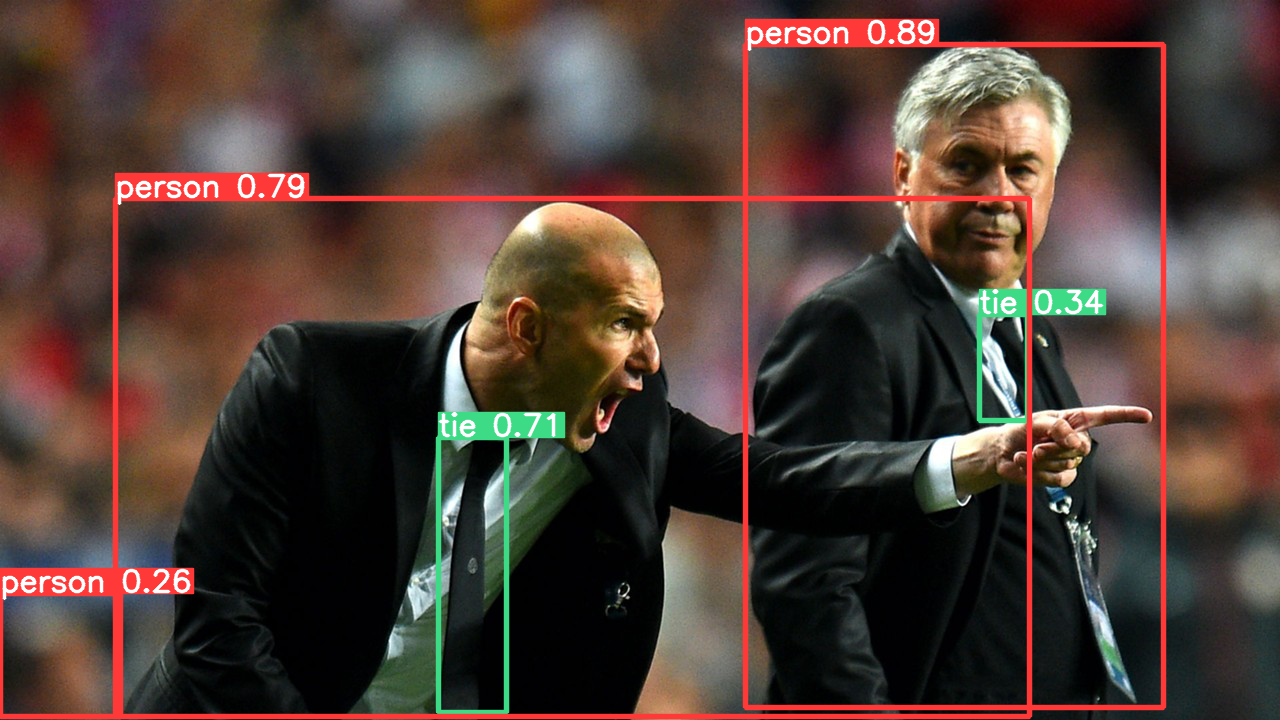

In [1]:

import yolov5

# load model
model = yolov5.load('yolov5s.pt')
  
# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image

# set image
img = 'https://github.com/ultralytics/yolov5/raw/master/data/images/zidane.jpg'

# perform inference
results = model(img)

# inference with larger input size
results = model(img, size=640)

# inference with test time augmentation
results = model(img, augment=True)

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

# show detection bounding boxes on image
results.show()

# save results into "results/" folder
# results.save(save_dir='results/')
